# Tutorial 7: Classification (Part II)

### Lecture and Tutorial Learning Goals:

After completing this week's lecture and tutorial work, you will be able to:

* Describe what a test data set is and how it is used in classification.
* Using R, evaluate classification accuracy using a test data set and appropriate metrics.
* Using R, execute cross validation in R to choose the number of neighbours.
* Identify when it is necessary to scale variables before classification and do this using R
* In a dataset with > 2 attributes, perform k-nearest neighbour classification in R using the `tidymodels` package to predict the class of a test dataset.
* Describe advantages and disadvantages of the k-nearest neighbour classification algorithm.


## Handwritten Digit Classification using R

<img src="https://media.giphy.com/media/UwrdbvJz1CNck/giphy.gif" width = "600"/>

Source: https://media.giphy.com/media/UwrdbvJz1CNck/giphy.gif

MNIST is a computer vision dataset that consists of images of handwritten digits like these:

![](img/MNIST.png)

It also includes labels for each image, telling us which digit it is. For example, the labels for the above images are 5, 0, 4, and 1.


In this tutorial, we’re going to train a classifier to look at images and predict what digits they are. Our goal isn’t to train a really elaborate model that achieves state-of-the-art performance, but rather to dip a toe into using classification with pixelated images. As such, we’re going to keep working with the simple K-nearest neighbour classifier we have been exploring in the last two weeks.



### Using image data for classification

As mentioned earlier, every MNIST data point has two parts: an image of a handwritten digit and a corresponding label. Both the training set and test set contain images and their corresponding labels.

Each image is 28 pixels by 28 pixels. We can interpret this as a big matrix of numbers:

<img src="img/MNIST-Matrix.png" width = "500"/>


We can flatten this matrix into a vector of 28x28 = 784 numbers and give it a class label (here 1 for the number one). It doesn’t matter how we flatten the array, as long as we’re consistent between images. From this perspective, the MNIST images are just a bunch of points in a 784-dimensional vector space, with a very rich structure.

<img src="img/matrix_to_row.png" width = "1000"/>


We do this for every image of the digits we have, and we create a data table like the one shown below that we can use for classification. Note, like any other classification problem that we have seen before, we need many observations for each class. This problem is also a bit different from the first classification problem we have encountered (Wisonsin breast cancer data set), in that we have more than two classes (here we have 10 classes, one for each digit from 0 to 9).

<img src="img/data_table.png" width = "700"/>

This information is taken from: https://tensorflow.rstudio.com/tensorflow/articles/tutorial_mnist_beginners.html

In [1]:
###
### Run this cell before continuing.
###

library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source('tests.R')
source("cleanup.R")

# functions needed to work with images
# code below sourced from: https://gist.github.com/daviddalpiaz/ae62ae5ccd0bada4b9acd6dbc9008706
# helper function for visualization
show_digit = function(arr784, col = gray(12:1 / 12), ...) {
  arr784$X <- 0  # avoid dark pixel in top left
  image(matrix(as.matrix(arr784[-785]), nrow = 28)[, 28:1], col = col, ...)
}

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

**Question 1.0** Multiple Choice:
<br> {points: 1}

How many rows and columns does the array of an image have?

A. 784 columns and 1 row

B. 28 columns and 1 row

C. 18 columns and 18 rows

D. 28 columns and 28 rows 

*Assign your answer to an object called `answer1.0`. Make sure the correct answer is an uppercase letter and to surround your answer with quotation marks (e.g. `"F"`).*

In [2]:
# Replace the fail() with your answer. 

answer1.0 <- "D"
answer1.0

[1] "D"

In [3]:
test_1.0()

[1] "Success!"


**Question 1.1** Multiple Choice: 
<br> {points: 1}

Once we linearize the array, how many rows represent a number?

A. 28

B. 784

C. 1

D. 18

*Assign your answer to an object called `answer1.1`. Make sure the correct answer is an uppercase letter and to surround your answer with quotation marks (e.g. `"F"`).*

In [4]:
# Replace the fail() with your answer. 

answer1.1 <- "C"
answer1.1

[1] "C"

In [5]:
test_1.1()

[1] "Success!"


## 2. Exploring the Data

Before we move on to do the modeling component, it is always required that we take a look at our data and understand the problem and the structure of the data well. We can start this part by loading the images and taking a look at the first rows of the dataset. You can load the data set by running the cell below. 

In [6]:
# Load images. 
# Run this cell. 
training_data <- read_csv('data/mnist_train_small.csv')
testing_data  <- read_csv('data/mnist_test_small.csv')

Parsed with column specification:
cols(
  .default = col_double()
)

See spec(...) for full column specifications.

Parsed with column specification:
cols(
  .default = col_double()
)

See spec(...) for full column specifications.



Look at the first 6 rows of `training_data`. What do you notice?

In [7]:
slice(training_data, 1:6)
dim(training_data)

X,X1,X2,X3,X4,X5,X6,X7,X8,X9,⋯,X775,X776,X777,X778,X779,X780,X781,X782,X783,X784
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


[1] 600 785

There are no class labels! This data set has already been split into the X's (which you loaded above) and the labels. In addition, there is an extra "X" column which represents the row number (1, 2, 3...). **Keep this in mind for now because we will remove it later on.** Now, let's load the labels.

In [8]:
# Run this cell. 
training_labels <- read_csv('data/mnist_train_label_small.csv')['y'] %>% mutate(y = as_factor(y))
testing_labels  <- read_csv('data/mnist_test_label_small.csv')['y'] %>% mutate(y = as_factor(y))

Parsed with column specification:
cols(
  X = col_double(),
  y = col_double()
)

Parsed with column specification:
cols(
  X = col_double(),
  y = col_double()
)



Look at the first 6 labels of `training_labels` using the `slice(data_frame, 1:6)` function. 

In [9]:
# Use this cell to view the first 6 labels.
# Run this cell.
slice(training_labels, 1:6)
slice(testing_labels, 1:6)

y
<fct>
5
0
4
1
9
2


y
<fct>
7
2
1
0
4
1


**Question 2.0**
<br> {points: 1}

How many rows does the training data set have? Note, each row is a different number in the postal code system. 

Use `nrow()`. Note, the testing data set should have fewer rows than the training data set.

*Assign your answer to an object called `number_of_rows`. Make sure your answer is a numeric and so it should not be surrounded by quotation marks.*

In [10]:
# Replace the fail() with your answer. 

number_of_rows <- training_labels %>% 
    nrow()
number_of_rows

[1] 600

In [11]:
test_2.0()

[1] "Success!"


**Question 2.1**
<br> {points: 1}

For mutli-class classification with k-nn it is important for the classes to have about the same number of observations in each class. For example, if  90% of our training set observationas were labeled as 2's, then k-nn classification predict 2 almost every time and we would get an accuracy score of 90% even though our classifier wasn't really doing a great job. 

Use the `group_by` and `summarize` function to get the counts for each group and see if the data set is balanced across the classes (has roughly equal numbers of observation for each class). Name the output `counts`. `counts` should be a data frame with 2 columns, `y` and `n` (the column `n` should have the counts for how many observations there were for each class group).

In [12]:
# Replace the fail() with your answer. 

counts <- training_labels %>%
    group_by(y) %>%
    summarize(n = n())
counts

`summarise()` ungrouping output (override with `.groups` argument)



y,n
<fct>,<int>
0,58
1,69
2,64
⋮,⋮
7,62
8,54
9,65


In [13]:
test_2.1()

[1] "Success!"


**Question 2.2** True or False:
<br> {points: 1}

The classes are not balanced. Some of them are *many times* larger or smaller than others. 

*Assign your answer to an object called `answer2.2`. Make sure your answer is in lowercase and is surrounded by quotation marks (e.g. `"true"` or `"false"`)*

In [14]:
# Replace the fail() with your answer. 

answer2.2 <- "false"
answer2.2

[1] "false"

In [15]:
test_2.2()

[1] "Success!"


To view an image in the notebook, you can use the `show_digit` function (we gave you the code for this function in the first code cell in the notebook, All you have to do to use it is run the cell below). The `show_digit` function takes the row from the dataset whose image you want to produce, which you can obtain using the `slice` function.

The code we provide below will show you the image for the observation in the 200th row from the training data set. 

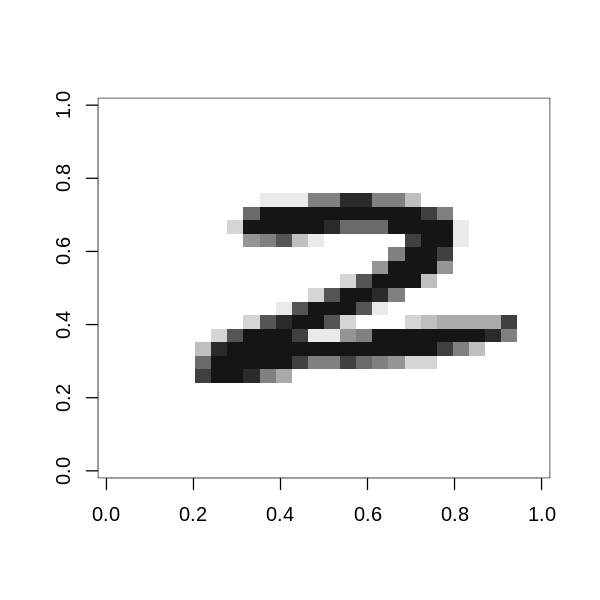

In [16]:
# Run this cell to get the images for the 200th row from the training data set.
options(repr.plot.height = 5, repr.plot.width = 5)
show_digit(slice(training_data, 200))

**Question 2.3** 
<br> {points: 3}

Show the image for row 102.

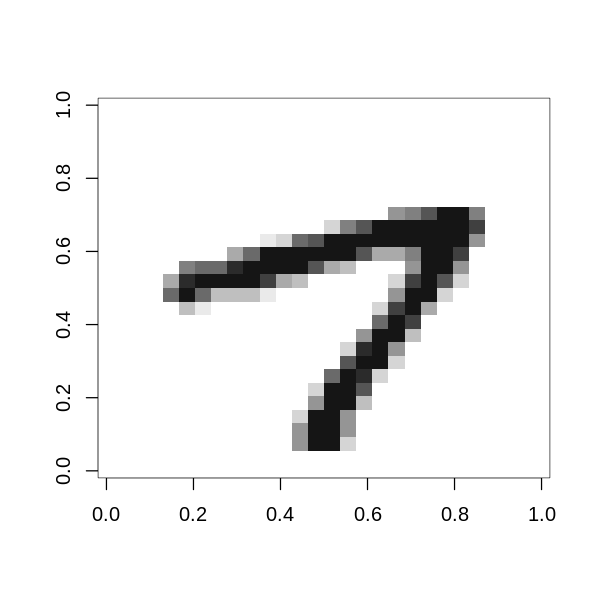

In [17]:
options(repr.plot.height = 5, repr.plot.width = 5)

# Replace the fail() with your answer. 


show_digit(slice(training_data, 102))

If you are unsure as to what number the plot is depicting (because the handwriting is messy) you can use `slice` to get the label from the `training_labels`:

In [18]:
# run this cell to get the training label for the 200th row
training_labels %>% 
    slice(200)

y
<fct>
2


**Question 2.4** 
<br> {points: 1}

What is the class label for row 102? Your answer should be a data frame with one column (named `y`) and one row.

*Assign your answer to an object called `label_102`.*

In [19]:
# Replace the fail() with your answer. 

label_102 <- training_labels %>% 
    slice(102)
label_102

y
<fct>
7


In [20]:
test_2.4()

[1] "Success!"


## 3. Splitting the Data

**Question 3.0**
<br> {points: 1}

Currently, the image data and labels are split. The `tidymodels` package needs the image data and labels to be combined together in one data frame. Given that the image data and labels are in the same order, we can use the `bind_cols` function to combine them. Name the training image data with its respective labels `training_set` and name the testing image data with its respective labels `testing_set`. 

> Note: even though the entire data set has been split for you already into a training and a test set, don't forget to do this in the future for other data sets where this is not the case. Remember, you need to have a training and testing data set when designing a useful k-nn classification model. 

Also, remember in Section 2 that we told you to keep something in mind? To remind you, there is an extra "X" column on the far left which represents the row numbers (1, 2, 3, etc.) in the `training_set`. **This column should not be used for training.** Therefore, let's remove this column from the data set. 

*Hint: You can remove columns in a dataset using the `select` function and by putting a negative sign infront of the column you want to exclude (e.g. `-X`)*.

In [21]:
# Set the seed. Don't remove this!
set.seed(9999) 

#... <- bind_cols(..., ...) %>% # for the training data
#        select(...)

#... <- bind_cols(..., ...) # for the testing data


training_set <- bind_cols(training_labels, training_data) %>% # for the training data
       select(-X)

testing_set <- bind_cols(testing_labels, testing_data) # for the testing data



In [22]:
test_3.0()

[1] "Success!"


**Question 3.1**
<br> {points: 3}

We have already split the data into two datasets, one for training purposes and one for testing purposes. **Is it important to split the data into a training and testing dataset when designing a knn classification model?** If yes, why do we do this? If no, explain why this is not a good idea.

Yes, It is important to split into a training and testing dataset when designing a knn classification model. This is because sometimes our classifier might give the wrong prediction. We must use only the training data set when building our classifier, then after we can hide the labels of the test set and use the classifier to predict the labels of the test set. If our predictions match the true labels for the observations in the test set, then we have some confidence that our classifier might also accurately predict the class labels for new observations without known class labels. 

However, we don't know if our classifier gives us the highest possible acuracy. But how do we test multiple different classifiers in a rubust fashion? The answer is to actually split the training dataset many more times and use cross-validation to compare which classifier provides the highest accuracy.

## Which $k$ should we use?

As you learned from the worksheet, we can use cross-validation on the training data set to select which $k$ is the most optimal for our data set for k-nn classification. 

**Question 3.2**
<br> {points: 1}

To get all the marks in this question, you will have to:
- Create a recipe that uses all predictors and a model specification with tuning on the number of neighbours (**Note: You don't need to scale or center this data**)
- Perform a 5-fold cross-validation on the training set
- Create a workflow analysis with your recipe and model specification and *specify that the tuning should try 10 values of $K$* 
- Collect the metrics from the workflow analysis 
- Plot the $k$ vs the accuracy
    - Assign this plot to an object called `cross_val_plot`

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,multiclass,0.7884222,5,0.015863247,Model01
3,accuracy,multiclass,0.8083949,5,0.004534446,Model02
5,accuracy,multiclass,0.7983375,5,0.005981672,Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
12,accuracy,multiclass,0.7549449,5,0.009623979,Model08
13,accuracy,multiclass,0.7499722,5,0.007095666,Model09
14,accuracy,multiclass,0.7449166,5,0.006358294,Model10


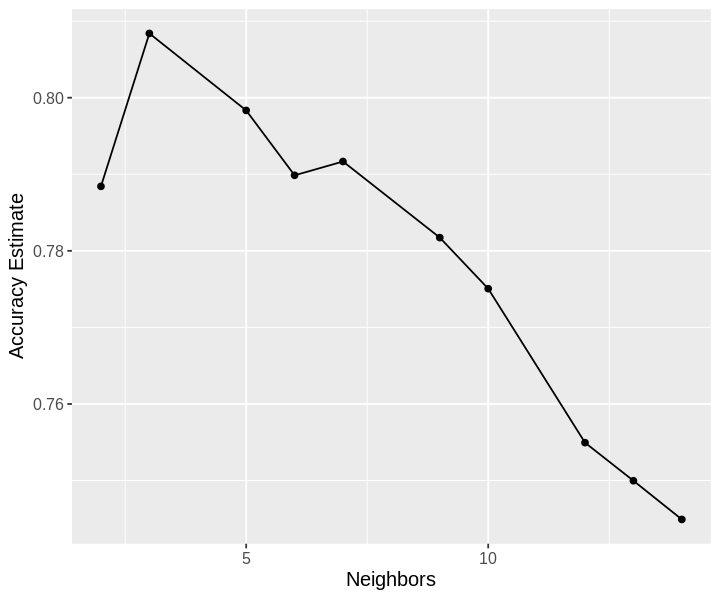

In [23]:
# Set the seed. Don't remove this!
set.seed(1234) 

options(repr.plot.height = 5, repr.plot.width = 6)

num_recipe <- recipe(y ~ ., data = training_set)

knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")

knn_spec

num_vfold <- vfold_cv(training_set, v = 5, strata = y)

knn_results <- workflow() %>%
  add_recipe(num_recipe) %>%
  add_model(knn_spec) %>%
  tune_grid(resamples = num_vfold, grid = 10) %>%
  collect_metrics() 

accuracy <- knn_results %>%
  filter(.metric == "accuracy")

accuracy


cross_val_plot <- ggplot(accuracy, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))

cross_val_plot

In [24]:
test_3.2()

[1] "Success!"


**Question 3.3**
<br> {points: 3}

Based on the plot from **Question 3.2**, which $k$ would you choose and how can you be sure about your decision? In your answer you should reference why we do cross-validation.

I would choose a K value of 3 for my analysis. This value has the highest accuracy at ~ 0.808 making it higher than any other choice. However, the difference in accuracy is very small between the different values of K, so a minor deviation anywhere between 2 and 7 is likely also fine. 

We can be sure about this result because we used cross validation. If we had split our overall training data once, our K-value choice would have depended strongly on which data was lucky enough to end up in the validation set. By using cross validation to create multiple different, non-random train/validation splits, we were able to get a better estimate of accuracy. This results in a better choice of K for the overall set of training data.

## 4. Let's build our model

**Question 4.0**
<br> {points: 3}

Now that we have explored our data, separated the data into training and testing sets (was technically done for you), and applied cross-validation to choose the best $k$, we can build our final model.

First, build your model specification with the best value for $K$. Assign your answer to an object called `mnist_spec`.

Then, pass the model specification and the training data set to the `fit()` function. Assign your answer to an object called `mnist_fit`.

In [25]:
# Set the seed. Don't remove this!
set.seed(9999) 

mnist_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) %>%
  set_engine("kknn") %>%
  set_mode("classification")
mnist_spec

mnist_fit <- workflow() %>%
  add_recipe(num_recipe) %>%
  add_model(mnist_spec) %>%
  fit(data = training_set)

mnist_fit

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 3
  weight_func = rectangular

Computational engine: kknn 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~3, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1983333
Best kernel: rectangular
Best k: 3

In [26]:
test_that('Did not create an object named mnist_spec', {
    expect_true(exists("mnist_spec"))
    })
test_that('Did not create an object named mnist_fit', {
    expect_true(exists("mnist_fit")) 
    })


**Question 4.1**
<br> {points: 1}

Use your final model to predict on the test dataset and assign this to an object called `mnist_predictions`. Report the accuracy of this prediction, and store this in an object named `mnist_metrics`. Also report the confusion matrix and and store this in an object named `mnist_conf_mat`. 

In [27]:
# Set the seed. Don't remove this!
set.seed(9999) 

mnist_predictions <- predict(mnist_fit, testing_set) %>%
    bind_cols(testing_set)
mnist_predictions


mnist_metrics <- mnist_predictions %>%
  metrics(truth = y, estimate = .pred_class) %>%
  filter(.metric == "accuracy")
mnist_metrics


mnist_conf_mat <- mnist_predictions %>%
             conf_mat(truth = y, estimate = .pred_class)
mnist_conf_mat

.pred_class,y,X,X1,X2,X3,X4,X5,X6,X7,⋯,X775,X776,X777,X778,X779,X780,X781,X782,X783,X784
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7,7,1,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,2,2,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1,1,3,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0,0,598,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
9,9,599,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
9,9,600,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.74


          Truth
Prediction  0  1  2  3  4  5  6  7  8  9
         0 51  0  1  0  0  1  2  0  3  0
         1  0 71 11  2  2  1  1  2  3  0
         2  0  0 34  4  1  0  3  2  3  0
         3  1  0  3 49  1  7  0  2  1  2
         4  0  0  1  0 46  2  3  0  2  5
         5  0  0  0  4  1 36  0  0  3  0
         6  0  0  2  0  2  1 41  0  1  0
         7  0  0  8  2  2  1  0 32  0  5
         8  1  2  4  1  0  6  2  1 32  0
         9  0  0  0  0 12  1  0 18  4 52

In [28]:
test_4.1()

[1] "Success!"


**Question 4.2**
<br> {points: 3}

For this exercise, print out 3 images and the true labels from the test set that were predicted correctly. 

To approach this exercise, we will first create a data frame that contains the predictions, and the labels from the testing set. We will want to use this data to find cases where the hand written digits were predicted correctly (i.e., any rows where the values in the predicted class label column, `.pred_class`, match the test set labels, `y`). We will then want to use this information to go back to the original data and extract images that correspond to these correct predictions. 

To keep track of which rows correspond to which images, we will use `mutate` to add a column called `seq`. This will order the rows, from 1 to $n$ (where $n$ is the number of images in the test set), and be useful to keep track of which rows correspond to which images when we do something to the data frame, for example, filter it to find correctly predicted labels. Scaffolding has been provided below for you. Assign your answer to an object called `mnist_predictions_with_labels`. 

From this data frame, filter for cases of equality between the predictions, `.pred_class`, and testing set labels, `y`. Essentially, you want to find cases where the predictions match the testing set labels. Sample 3 rows of data using `sample_n`. Assign your answer to an object called `matching`. 

Next, we want to extract the row numbers (`seq`) from the `matching` data frame to input them into the `show_digit` function. The scaffolding to extract the data from the first row and the associated row number is provided below. Assign your answers respectively to `matching_1`, `matching_2`, and `matching_3`. 

*Use `show_digit` to visualize the digits indexed by `matching_1`, `matching_2`, and `matching_3` to see what they look like!*

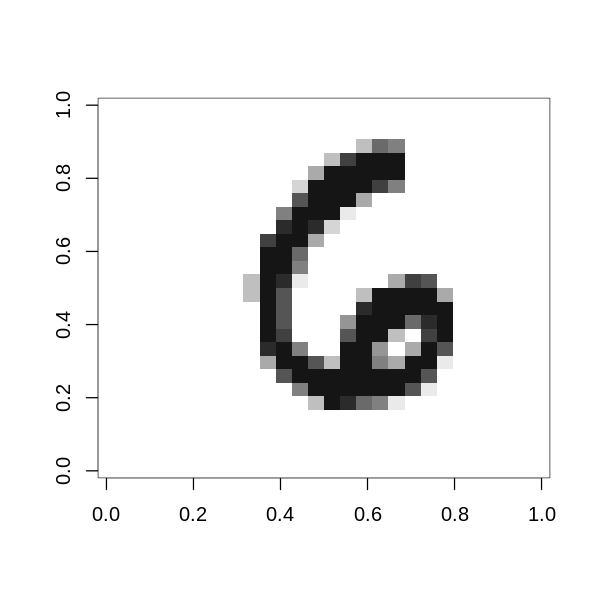

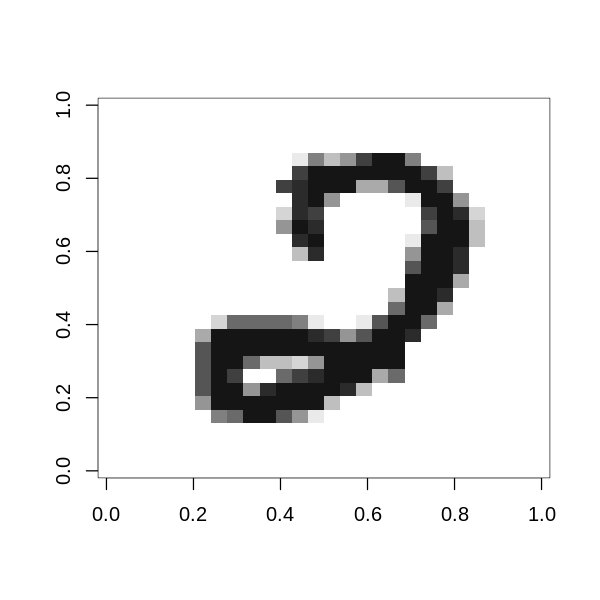

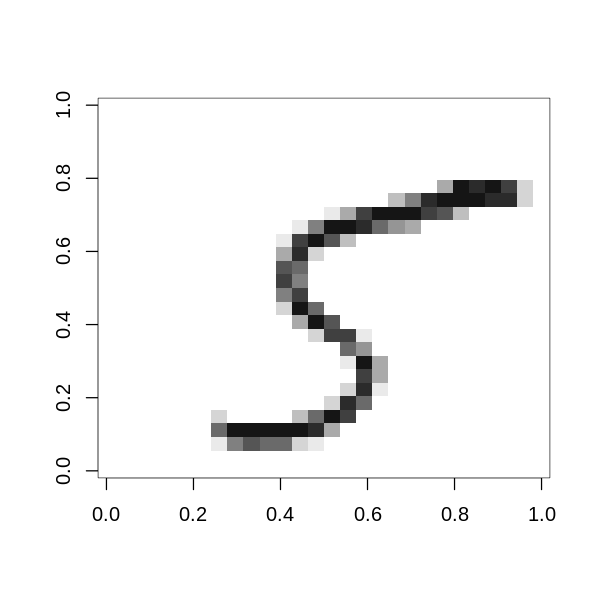

In [29]:
# Set the seed. Don't remove this!
set.seed(1000) 
options(repr.plot.height = 5, repr.plot.width = 5)

#... <- mnist_predictions %>%
#       select(...) %>%
#       bind_cols(testing_set %>% select(...)) %>%
#       mutate(... = 1:nrow(...)) %>%
#       as.data.frame()

#... <- mnist_predictions_with_labels %>%
#          filter(... == ...) %>%
#          sample_n(...) %>%

#... <- matching %>%
#          slice(1) %>%
#          select(...) %>%
#          pull()

# show_digit(slice(..., ...))
# show_digit(slice(..., ...))
# show_digit(slice(..., ...))


mnist_predictions_with_labels <- mnist_predictions %>%
      select(.pred_class) %>%
      bind_cols(testing_set %>% select(y)) %>%
      mutate(seq = 1:nrow(testing_set)) %>%
      as.data.frame()

matching <- mnist_predictions_with_labels %>%
         filter(.pred_class == y) %>%
         sample_n(3)

matching_1 <- matching %>%
         slice(1) %>%
         select(seq) %>%
         pull()

matching_2 <- matching %>%
         slice(2) %>%
         select(seq) %>%
         pull()

matching_3 <- matching %>%
         slice(3) %>%
         select(seq) %>%
         pull()


show_digit(slice(testing_data, matching_1))
show_digit(slice(testing_data, matching_2))
show_digit(slice(testing_data, matching_3))

In [30]:
test_that('Did not create an object named mnist_predictions_with_labels', {
    expect_true(exists('mnist_predictions_with_labels'))
})
test_that('Did not create an object named matching', {
    expect_true(exists('matching'))
})
test_that('Did not create an object called matching_1', {
    expect_true(exists('matching_1'))
})
test_that('Did not create an object called matching_2', {
    expect_true(exists('matching_2'))
})
test_that('Did not create an object called matching_3', {
    expect_true(exists('matching_3'))
})


**Question 4.3**
<br> {points: 1}

Print out 3 images and true labels from the test set that were **NOT** predicted correctly. You can reuse the `mnist_predictions_with_labels` data frame from **Question 4.2**. 

Filter for inequality between the predictions and the labels for the testing set in a data frame called `not_matching`. Afterwards, extract the row number and assign them to `not_matching_1`, `not_matching_2`, and `not_matching_3` respectively. If you need help, refer to the instructions in **Question 4.2**. 

Similar to the previous question, use the `show_digit` function we gave you above to print out the images.

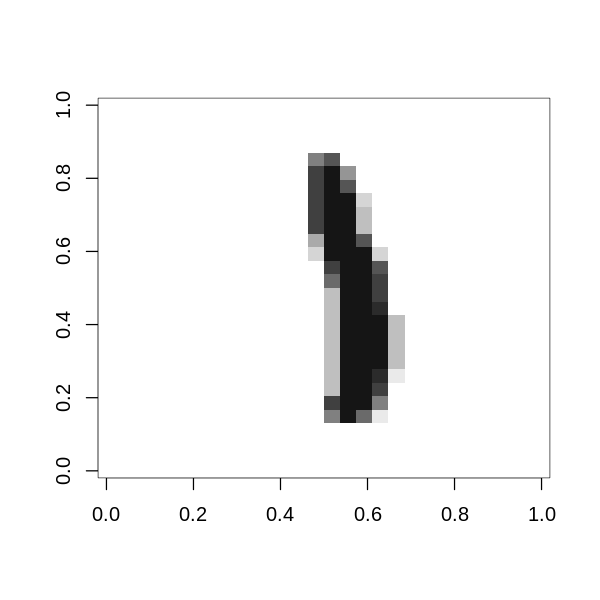

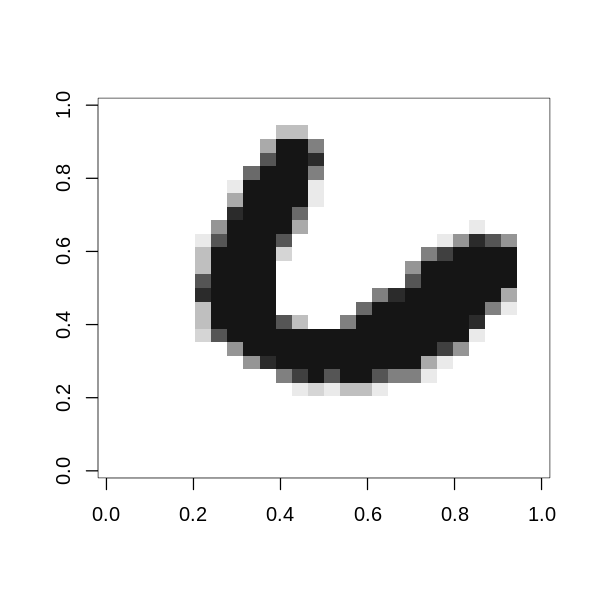

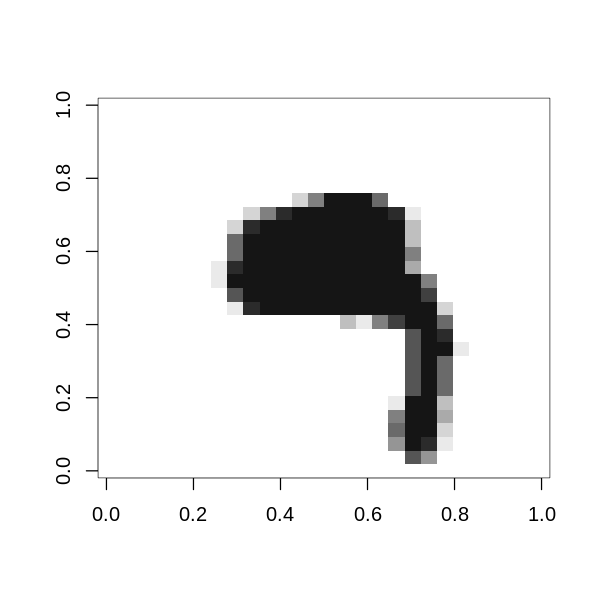

In [31]:
# Set the seed. Don't remove this!
set.seed(3500) 

options(repr.plot.height = 5, repr.plot.width = 5)


not_matching <- mnist_predictions_with_labels %>%
         filter(.pred_class != y) %>%
         sample_n(3)

not_matching_1 <- not_matching %>%
         slice(1) %>%
         select(seq) %>%
         pull()

not_matching_2 <- not_matching %>%
         slice(2) %>%
         select(seq) %>%
         pull()

not_matching_3 <- not_matching %>%
         slice(3) %>%
         select(seq) %>%
         pull()


show_digit(slice(testing_data, not_matching_1))
show_digit(slice(testing_data, not_matching_2))
show_digit(slice(testing_data, not_matching_3))

In [32]:
test_that('Did not create an object named not_matching', {
    expect_true(exists('not_matching'))
})
test_that('Did not create an object called not_matching_1', {
    expect_true(exists('not_matching_1'))
})
test_that('Did not create an object called not_matching_2', {
    expect_true(exists('not_matching_2'))
})
test_that('Did not create an object called not_matching_3', {
    expect_true(exists('not_matching_3'))
})


**Question 4.4** True or False:
<br> {points: 1}

The above images were predicted incorrectly due to messy handwriting. For example, the second image is illegible and actually looks like the letter "U".

*Assign your answer to an object called `answer4.4`. Make sure your answer is in lowercase and is surrounded by quotation marks (e.g. `"true"` or `"false"`).*

In [33]:
# Replace the fail() with your answer. 

answer4.4 <- "true"
answer4.4

[1] "true"

In [34]:
test_4.4()

[1] "Success!"


**Question 4.5**
<br> {points: 3}

Looking again at the results from **Question 4.1**, what does this accuracy mean? Is it good enough that you would use this model for the Canada Post? Can you imagine a way we might improve our classifier's accuracy?

The accuracy value was ~ .74 when we applied the K value of 3 for our prediction. This means that the correst number was only predicted approximately 74 percent of the time in our testing set. 

This model would not be good enough to use for the Canada Post. Mail needs to be sent to the correct location every time, and the frequency of inaccurate predictions of numbers would definitely cause mail to be sent to erroneous locations. When mail is not sent to the correct location it causes massive delays that could have terribel consequences. Therefore, we would need to improve the accuracy before employing this system in a serious setting like the Canada Post.

We could increase the number of folds in our cross validation. However, this would increase the computing time and be costly for what would likely be only a minor improvement in accuracy. Additionally, we could increase the size of our training and testing data sets so that they have more material to work with when tuning our K value to the optimum number.

In [35]:
source("cleanup.R")